# Large Model Example

Large models (schedules >~ 2 weeks) create a large number of variables due to the exponential variable scaling inherit to LMAS consumption constraints.

To solve large models a number of options exist:
- Solve with no LMAS constraints
    - Allows for model solutions, but likely will create impossible production schedules
- Solve smaller models sequentially for full production schedule
    - Break full schedule into ~2 week schedules and solve sequentially building off of previous solutions which are fixed in time
- Use sequential models to reduce model `horizon`
    - Long schedules require large horizon (maximum time provided for a model solution). Reducing the maximum horizon can greatly impact model solution time and can be informed by the sequential model approach

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# %%
from scheduleopt import ScheduleModel
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import json
import numpy as np
import pandas as pd
from tqdm import tqdm


with open("input_lmas_ramp_updated") as f:
    inputs = json.load(f)
inputs["forecast"] = inputs["forecast"]
# inputs["forecast"] = [["M07A5", 60361, 744]]
# inputs["forecast"] = inputs["forecast1"]
# print(inputs["forecast"])
# with open("input_test/input_sample.json") as f:
#     inputs = json.load(f)

model = ScheduleModel(inputs, time_scale_factor=4)

In [2]:
# %%
# sol = model.solve_minimize_delivery_miss(max_time_in_seconds=None, verbose=True)
sol = model.solve_least_time_schedule(max_time_in_seconds=None, number_of_search_workers=None, verbose=True, enforce_consumption_constraint=False)
# %%


Starting CP-SAT solver v9.6.2534
Parameters: random_seed: 1 log_search_progress: true num_search_workers: 16

Initial optimization model '': (model_fingerprint: 0x94fb6d74f86a19c2)
#Variables: 5429 (#ints:1 in objective)
  - 4391 Booleans in [0,1]
  - 749 in [0,6416]
  - 289 constants in {2,4,6,8,12,15,16,20,28,29,32,34,39,46,47,48,64,96,108,144,158} 
#kInterval: 359 (#enforced: 329)
#kLinMax: 1 (#expressions: 30)
#kLinear1: 6960 (#enforced: 6960)
#kLinear2: 3781 (#enforced: 3728)
#kLinear3: 319 (#enforced: 289)
#kLinearN: 91 (#enforced: 90) (#terms: 5280)
#kNoOverlap: 8 (#intervals: 339, #optional: 309, #variable_sizes: 30)

Starting presolve at 0.00s
[ExtractEncodingFromLinear] #potential_supersets=30 #potential_subsets=0 #at_most_one_encodings=0 #exactly_one_encodings=0 #unique_terms=0 #multiple_terms=0 #literals=0 time=6.5901e-05s
[SAT presolve] num removable Booleans: 3005 / 5429
[SAT presolve] num trivial clauses: 0
[SAT presolve] [0s] clauses:40 literals:80 vars:40 one_side_var

In [3]:
jobs_chart = sol.visualize_jobs()
machines_chart = sol.visualize_machines()
jobs_chart

alt.Chart(...)

In [4]:
machines_chart

alt.Chart(...)

## Previous Schedule

Use initial model with no LMAS constraints to provide starting point for serious of smaller models.

Smaller models will be built sequentially over time periods less than the full model time period to provide solvable constraints. 

Final model solution created using new maximum horizon from sequential model.

In [5]:
jobs = sol.job_schedule.loc[sol.job_schedule["MIN"] != "LMAS"].sort_values("Start")[["MIN", "JobId"]].drop_duplicates()
jobs.shape[0]

32

In [6]:
list(range(0,len(jobs) + 1, 5))

[0, 5, 10, 15, 20, 25, 30]

In [7]:
prev_n = 0
forecasts = []
for n in range(5,len(jobs)+1, 8):
    jobs_data = jobs.iloc[prev_n:n]
    num_batches = jobs_data["MIN"].value_counts()
    batches = pd.Series(sol.input_data.batches)
    amounts = (num_batches * batches).dropna().astype(int).reset_index()
    amounts["time"] = 744
    forecasts.append(amounts.to_dict(orient="split")["data"])
    prev_n = n

In [8]:
forecasts

[[['M07A5', 21039, 744], ['M09C2', 39116, 744]],
 [['A09B4', 91525, 744], ['M07A5', 42078, 744], ['M09C2', 9779, 744]],
 [['A09B4', 18305, 744],
  ['D07D2', 20905, 744],
  ['K05B8', 47620, 744],
  ['M07A5', 42078, 744]],
 [['D07D2', 20905, 744], ['J07B1', 40824, 744], ['M07A5', 63117, 744]]]

In [9]:
forecast = forecasts[1]

In [10]:
len(forecasts)

4

In [11]:
help(ScheduleModel)

Help on class ScheduleModel in module scheduleopt.schedule_model:

class ScheduleModel(builtins.object)
 |  ScheduleModel(input_data: Union[dict, scheduleopt.input_schema.ModelData, str, pathlib.Path], previous_schedule: pandas.core.frame.DataFrame = None, schedule_hint: pandas.core.frame.DataFrame = None, cleaning_matrix: Optional[Dict[int, Union[pandas.core.frame.DataFrame, str, pathlib.Path]]] = None, time_scale_factor: int = 2)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_data: Union[dict, scheduleopt.input_schema.ModelData, str, pathlib.Path], previous_schedule: pandas.core.frame.DataFrame = None, schedule_hint: pandas.core.frame.DataFrame = None, cleaning_matrix: Optional[Dict[int, Union[pandas.core.frame.DataFrame, str, pathlib.Path]]] = None, time_scale_factor: int = 2)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  solve_least_time_schedule(self, enforce_consumption_constraint=True, max_time_in_seconds=45, number_of_search_worke

In [9]:
sol.job_schedule

,Machine,MIN,JobId,TaskId,Start,End,Activity,Operation,MachineId,ConsumptionRate,Expired
0,Reactor-358,M09C2,22,0,0.00,2.00,M09C2 - Reactor-358,M09C2 - Reactor-358,0,0.000000,0
1,Reactor-358,M09C2,22,1,2.00,2.50,M09C2 - Reactor-358,M09C2 - Reactor-358,0,0.333333,0
2,Reactor-358,M09C2,22,2,2.50,6.50,M09C2 - Reactor-358,M09C2 - Reactor-358,0,0.800000,0
3,Reactor-358,M09C2,22,3,6.50,8.50,M09C2 - Reactor-358,M09C2 - Reactor-358,0,0.000000,0
4,Reactor-358,M09C2,22,DI Rinse,8.50,9.00,M09C2 - Reactor-358,M09C2-M09C2-DI Rinse,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
314,UF4,J07B1,37,4,281.50,308.50,J07B1 - UF4,J07B1 - UF4,7,0.000000,0
315,UF4,J07B1,40,4,308.50,335.50,J07B1 - UF4,J07B1 - UF4,7,0.000000,0
316,UF4,W05Z5,49,4,345.25,381.25,W05Z5 - UF4,W05Z5 - UF4,7,0.000000,0
317,UF4,W05Z5,52,4,382.50,418.50,W05Z5 - UF4,W05Z5 - UF4,7,0.000000,0


In [ ]:
solutions = []
max_times = [1500, 3000, 1500, 1500, 300, 300, 300]
prev_sol = None
for max_time, forecast in tqdm(zip(max_times, forecasts)):
    inputs["forecast"] = forecast
    # %
    # part_model = ScheduleModel(inputs, time_scale_factor=4)
    if prev_sol is None:
        part_model = ScheduleModel(inputs, time_scale_factor=4)
    else:
        part_model = ScheduleModel(inputs, time_scale_factor=4, previous_schedule=prev_sol.job_schedule)
    # sol = model.solve_minimize_delivery_miss(max_time_in_seconds=None, verbose=True)
    solb = part_model.solve_least_time_schedule(max_time_in_seconds=max_time, number_of_search_workers=None, verbose=False, enforce_consumption_constraint=True)
    solutions.append(solb)
    prev_sol = solb
    jobs_chart = solb.visualize_jobs()
    machines_chart = solb.visualize_machines()
    jobs_chart.display()
    machines_chart.display()

0it [00:00, ?it/s]

Solution 0, time = 4.146342 s, objective = 375
Solution 1, time = 4.758870 s, objective = 368
Solution 2, time = 4.769717 s, objective = 367
Solution 3, time = 4.779626 s, objective = 366
Solution 4, time = 4.790932 s, objective = 361
Solution 5, time = 4.800695 s, objective = 360
Solution 6, time = 4.811551 s, objective = 349
Solution 7, time = 4.822239 s, objective = 348
Solution 8, time = 4.832887 s, objective = 347
Solution 9, time = 4.843947 s, objective = 346
Solution 10, time = 4.854062 s, objective = 345
Solution 11, time = 4.904727 s, objective = 344
Solution 12, time = 4.930175 s, objective = 343
Solution 13, time = 4.942851 s, objective = 342
Solution 14, time = 4.966869 s, objective = 341
Solution 15, time = 5.299170 s, objective = 340
Solution 16, time = 5.311253 s, objective = 339
Solution 17, time = 5.322866 s, objective = 338
Solution 18, time = 5.333710 s, objective = 332
Solution 19, time = 5.344353 s, objective = 331
Solution 20, time = 5.355015 s, objective = 330
So

alt.Chart(...)

alt.Chart(...)

1it [01:31, 91.54s/it]

Solution 0, time = 34.059760 s, objective = 923
Solution 1, time = 35.722993 s, objective = 921
Solution 2, time = 37.529432 s, objective = 919
Solution 3, time = 39.561782 s, objective = 917
Solution 4, time = 41.250806 s, objective = 915
Solution 5, time = 42.999170 s, objective = 913
Solution 6, time = 64.437112 s, objective = 912
Solution 7, time = 71.067247 s, objective = 911
Solution 8, time = 72.090422 s, objective = 910
Solution 9, time = 75.411608 s, objective = 909
Solution 10, time = 75.761460 s, objective = 908
Solution 11, time = 77.349317 s, objective = 907
Solution 12, time = 80.065898 s, objective = 906
Solution 13, time = 83.044531 s, objective = 905
Solution 14, time = 83.204761 s, objective = 902
Solution 15, time = 83.559582 s, objective = 893
Solution 16, time = 87.699434 s, objective = 892
Solution 17, time = 88.085102 s, objective = 891
Solution 18, time = 88.151044 s, objective = 890
Solution 19, time = 94.486129 s, objective = 889
Solution 20, time = 96.988175 

alt.Chart(...)

alt.Chart(...)

2it [12:38, 430.04s/it]

<Axes: xlabel='Time'>

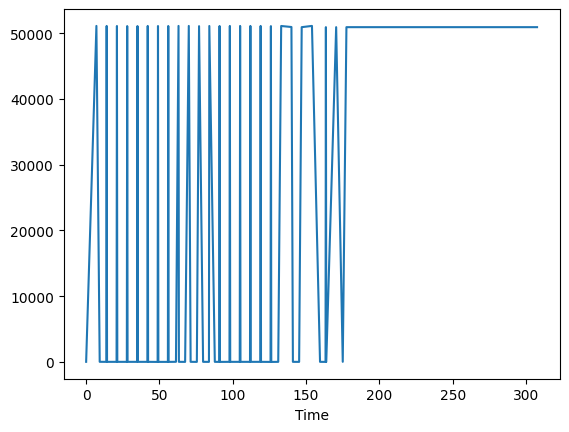

In [28]:
solb.net_production["LMAS"].plot()

In [12]:
forecast

[['A09B4', 91525, 744], ['M07A5', 42078, 744], ['M09C2', 9779, 744]]

In [26]:
prev_sol.solver.StatusName()

'INFEASIBLE'

In [ ]:
solutions[-2].job_schedule.to_csv("sol1_schedule.csv", index=False)

In [ ]:
prev_sol=solutions[0]
part_model = ScheduleModel(inputs, time_scale_factor=4, previous_schedule=prev_sol.job_schedule)
# sol = model.solve_minimize_delivery_miss(max_time_in_seconds=None, verbose=True)
solb = part_model.solve_least_time_schedule(max_time_in_seconds=2500, number_of_search_workers=None, verbose=True, enforce_consumption_constraint=True)

In [ ]:
len(solutions)

In [ ]:
solb = part_model.solve_least_time_schedule(max_time_in_seconds=1500, number_of_search_workers=None, verbose=False, enforce_consumption_constraint=True)

In [ ]:
solutions[-1].job_schedule.to_csv("final_schedule.csv"),index=False)